neccessary imports, setting the compute device, setting seed, loading the network and scalers

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import random
import torch 
import pickle
import optuna 
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.preprocessing import MinMaxScaler
## user inputs ## 
# names and directories 
model_name = "forward_MLP.pth" 
scaler_model_dir_name = "network_data"  
input_scaler_filename = "input_scaler.pkl" 
state_scaler_filename = "state_scaler.pkl"
# neural network configuration  
lag_input = 0 
lag_state = 1 
max_lag = max(lag_state, lag_state)
num_hidden_layers = 0
hidden_units = 30 
input_flat_size = 6 + (lag_state*6) + 3 + (lag_input*3) 
output_size = 6 
n_states = 6 
n_inputs = 3 
mid_x_idx = 0 
mid_y_idx = 1 
mid_z_idx = 2 
ee_x_idx = 3 
ee_y_idx = 4 
ee_z_idx = 5 
# indices correspond to raw ROS logs 
act_1_idx_ros = 0 
act_2_idx_ros = 1 
act_3_idx_ros = 2 
mid_x_idx_ros = 3 
mid_y_idx_ros = 4 
mid_z_idx_ros = 5 
ee_x_idx_ros = 6 
ee_y_idx_ros = 7 
ee_z_idx_ros = 8 
# initial condittions
x_intial = np.array([3.3065416622541037e-06, 0, -0.19036912150652113, 6.0826336879046396e-06, 0, -0.3907576704717413])
X = np.tile(x_intial, (max_lag+1,1)) # handling the state lags
u_initial = np.array([0,0,0]) 
U = np.tile(u_initial, (max_lag+1, 1))  # handling the input lags 
# optimization parameters
umax = 12 # max input 
dumax = 12 # max input change (from dataset)
tmax = 3  # max simulation time
dt = 0.1 # sampling time 
total_steps = int(tmax/dt) 
z_g = -1 # structure height 
g = 9.8 # gravity acceleration
des_land_pos = [0.1, 0.1] # desired landing pose 
Q = 1 # landing pose weight term  
n_trials = 1000 # number of trials

# selecting the compute device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"using compute device: {device}") 
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")   

# setting seeds 
def set_all_seeds(seed: int = 42):
    """
    sets the seeds for python, numpy, and pytoch (CPU & GPU) 
    """
    # python random module
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    # pytorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}") 
set_all_seeds() 

# defining the model 
# the model is a nn that gives x_k+1 based on current and previous states as well as inputs 
class MLP_model(torch.nn.Module): 
    def __init__(self, input_flat_size:int, hidden_units:int, output_size:int, num_hidden_layers:int) :
        super().__init__()
        self.input_flat_size = input_flat_size 
        self.hidden_units = hidden_units 
        self.output_size = output_size 
        self.num_hidden_layers = num_hidden_layers 

        hidden_layers = [] 

        in_dimension = self.input_flat_size 

        self.input_layer = torch.nn.Linear(in_features=in_dimension, out_features=self.hidden_units) 
        
        for i in range(self.num_hidden_layers) : 
            hidden_layers.append(torch.nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units)) 
            hidden_layers.append(torch.nn.ReLU()) 

        self.backbone = torch.nn.Sequential(*hidden_layers) 
        
        self.output_layer = torch.nn.Linear(in_features=self.hidden_units, out_features=self.output_size) 
 
        self.relu = torch.nn.ReLU()    

    def forward(self,x): 
        out = self.input_layer(x) 
        out = self.relu(out)
        out = self.backbone(out)  
        out = self.output_layer(out) 
        return out  

# instantiating an NN object 
forward_model = MLP_model(input_flat_size=input_flat_size, hidden_units=hidden_units, output_size=output_size, num_hidden_layers=num_hidden_layers) 

# loading the statedicts 
script_path = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd() 
model_data_path = os.path.join(script_path, scaler_model_dir_name) 
forward_model.load_state_dict(torch.load(os.path.join(model_data_path, model_name), weights_only=True)) 
forward_model = forward_model.to(device=device) 
forward_model.eval()  

# loading the scalers 
with open(os.path.join(model_data_path, input_scaler_filename), "rb") as file : 
    input_scaler = pickle.load(file) 
with open(os.path.join(model_data_path, state_scaler_filename), "rb") as file : 
    state_scaler = pickle.load(file)

using compute device: cpu
Seeds set to 42


defining the function to simulate the system given the decision variables

In [11]:
def simulate_sys(u_step: np.array, ramp_steps: int, release_step: int, input_scaler: MinMaxScaler, state_scaler: MinMaxScaler) : 
        
        # configuring the inputs
        # creating the ramp profile 
        ramp_factor = np.linspace(0, 1, ramp_steps) 
        ramp_factor = np.repeat(ramp_factor[:,None], n_inputs, axis=1) 
        # creating the ramp array 
        u_ramp = ramp_factor * u_step 
        # padding the remaining input array with the final hold value 
        hold_steps = total_steps - ramp_steps 
        if hold_steps > 0 : 
            u_hold = np.tile(u_step, (hold_steps,1)) 
            u_array = np.vstack((u_ramp, u_hold)) 
        else : 
            u_array = u_ramp 

        # stacking input zeros (crucial for the simulation)(to have the prefilled states) 
        zeros = np.zeros((max_lag+1, n_inputs)) 
        u_array = np.vstack((zeros, u_array))  

        # scaling the input array, initial states and conversion to torch tensor  
        u_array_scaled = input_scaler.transform(u_array) 
        u_array_torch = torch.from_numpy(u_array_scaled).type(torch.float32) 
        X_init = state_scaler.transform(X) 
        X_init_scaled = torch.from_numpy(X_init).type(torch.float32) 

        # rollout (dynamics simulation) :
        # initial buffer 
        current_state = X_init_scaled[max_lag,:] 
        if lag_state == 0 : 
            past_state = X_init_scaled[max_lag:max_lag] 
        else : 
            past_state = X_init_scaled[max_lag-lag_state:max_lag,:] 
            past_state = torch.flatten(input=past_state) 
        current_input = u_array_torch[max_lag,:] 
        if lag_input == 0 : 
            past_input = u_array_torch[max_lag:max_lag,:]
        else : 
            past_input = u_array_torch[max_lag-lag_input:max_lag,:] 
            past_input = torch.flatten(input=past_input) 

        if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((current_state, current_input), dim=0) 
        elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
            joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
        elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
            joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
        else : 
            joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0)

        preds = [] 

        # creating the zero tensor array to act as a buffer for the predicted states
        X_buffer = torch.zeros(len(u_array_torch), n_states)
        for i in range(max_lag+1) : 
            X_buffer[i,:] = X_init_scaled[i,:] 

        with torch.inference_mode(): 
            for i in range(max_lag+1, len(u_array_torch)) : 
                pred = forward_model(joined_features.unsqueeze(0)) 
                pred = pred.squeeze(0) 

                preds.append(pred) 
                X_buffer[i,:] = pred 

                # updating the buffer 
                current_state = pred
                if lag_state == 0 : 
                    past_state = X_buffer[i:i] 
                else : 
                    past_state = X_buffer[i-lag_state:i,:] 
                    past_state = torch.flatten(input=past_state) 
                current_input = u_array_torch[i,:] 
                if lag_input == 0 : 
                    past_input = u_array_torch[i:i,:]
                else : 
                    past_input = u_array_torch[i-lag_input:i,:] 
                    past_input = torch.flatten(input=past_input) 

                if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((current_state, current_input), dim=0) 
                elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                    joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
                elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                    joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
                else : 
                    joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0)
        
        preds_tensor = torch.stack(preds, dim=0) 
        preds_np = preds_tensor.numpy()  

        # unscaling the predictions (states corrresponding to the inputs)  
        preds_np = state_scaler.inverse_transform(preds_np) 

        # calculating the veloctiy  
        diff = np.diff(preds_np, axis=0) 
        velocities = np.vstack([np.zeros((1, n_states)), diff / dt]) 

        # predicting the landing positions 
        delta_z = preds_np[:, -1] - z_g 
        sqrt_term = velocities[:,-1]**2 + (2 * g * delta_z)
        t_flight = (velocities[:,-1] + np.sqrt(sqrt_term)) / g 
        x_landing = preds_np[:,ee_x_idx] + velocities[:,ee_x_idx] * t_flight
        y_landing = preds_np[:,ee_y_idx] + velocities[:,ee_y_idx] * t_flight  

        # actual landing based on the release time 
        idx = min(release_step, len(x_landing) - 1) #since python uses 0 indexing
        act_landing_x = x_landing[idx] 
        act_landing_y = y_landing[idx]
        land_pos = np.array([act_landing_x, act_landing_y]) 

        # distance to the goal 
        dist = np.linalg.norm(des_land_pos - land_pos) 

        return u_array, preds_np, velocities, land_pos, idx, dist

defining the objective function

In [12]:
def objective(trial) : 
    # decision variables : 
    # actuator inputs 
    u1_step = trial.suggest_float("act1_step", 0, umax) # actuator 1 
    u2_step = trial.suggest_float("act2_step", 0, umax) # actuator 2
    u3_step = trial.suggest_float("act3_step", 0, umax) # actuator 3 
    u_step = np.array([u1_step, u2_step, u3_step]) # shape (,3)
    # ramp and release time steps  
    ramp_steps = trial.suggest_int("ramp_steps", 3, total_steps) 
    release_step = trial.suggest_int("release_step", 0, ramp_steps)  

    _, _, _, _, _, dist = simulate_sys(u_step=u_step, ramp_steps=ramp_steps, release_step=release_step, input_scaler=input_scaler, state_scaler=state_scaler)    

    cost = Q * dist 
    
    return cost

bayesian optimization settings and initiation

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials, show_progress_bar=True) 

[I 2026-01-27 13:32:33,247] A new study created in memory with name: no-name-6ec50f59-659b-4300-b127-fb5ce1ed9010


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2026-01-27 13:32:33,329] Trial 0 finished with value: 0.1523877992821175 and parameters: {'act1_step': 8.68025910547542, 'act2_step': 0.9164357587020651, 'act3_step': 7.07323182233776, 'ramp_steps': 7, 'release_step': 6}. Best is trial 0 with value: 0.1523877992821175.
[I 2026-01-27 13:32:33,371] Trial 1 finished with value: 0.1342135808487987 and parameters: {'act1_step': 2.974906145552305, 'act2_step': 7.288574683645913, 'act3_step': 5.427411517072173, 'ramp_steps': 18, 'release_step': 16}. Best is trial 1 with value: 0.1342135808487987.
[I 2026-01-27 13:32:33,426] Trial 2 finished with value: 0.16491342552968666 and parameters: {'act1_step': 9.84205953817362, 'act2_step': 3.0729178801339407, 'act3_step': 4.799101167005864, 'ramp_steps': 25, 'release_step': 17}. Best is trial 1 with value: 0.1342135808487987.
[I 2026-01-27 13:32:33,466] Trial 3 finished with value: 0.08617279387245216 and parameters: {'act1_step': 1.02606413350789, 'act2_step': 2.1630078973814464, 'act3_step': 11.

visualizing the trajectory 

Best Parameters Found:
  act1_step: 0.9265
  act2_step: 3.5239
  act3_step: 10.0080
  ramp_steps: 4.0000
  release_step: 3.0000

Best Objective Value (Cost): 0.0013
final distance:  0.0012955724221851478


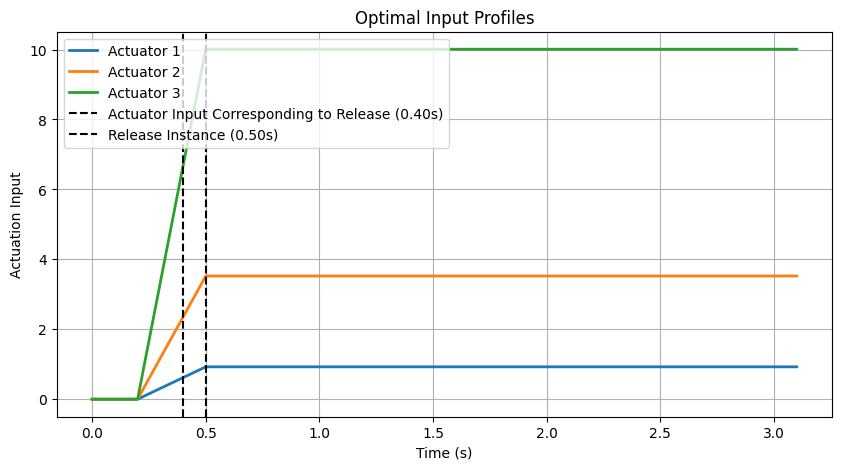

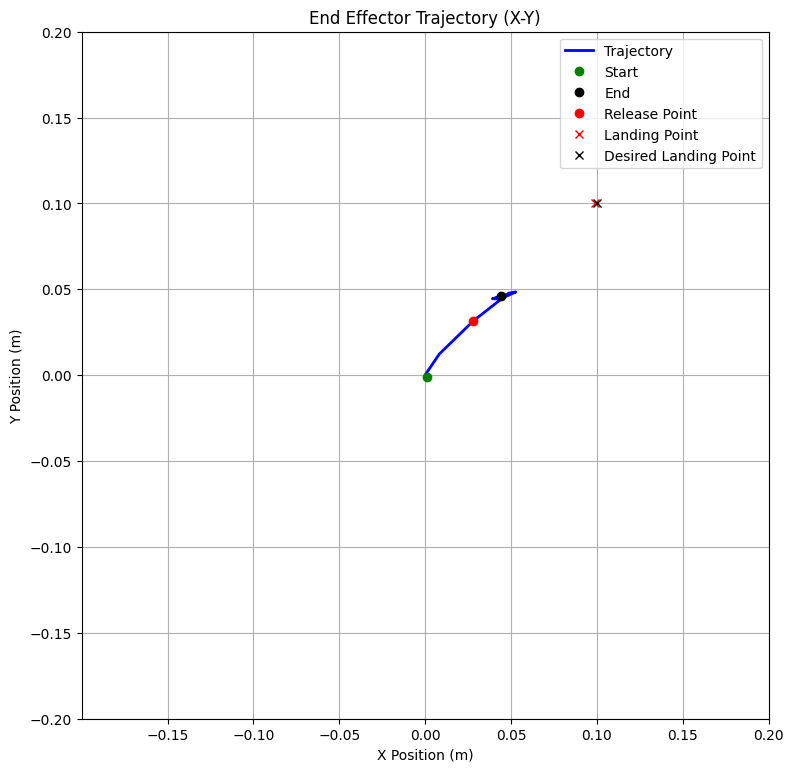

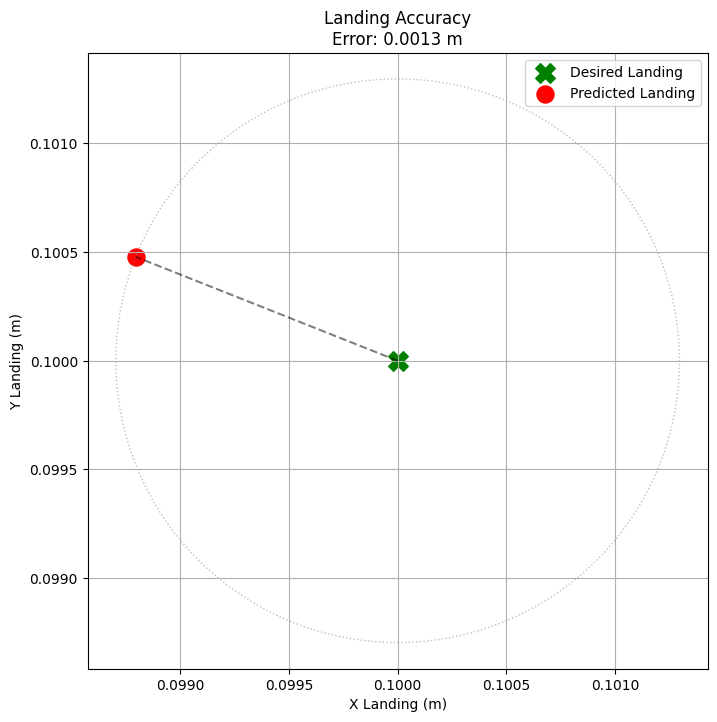

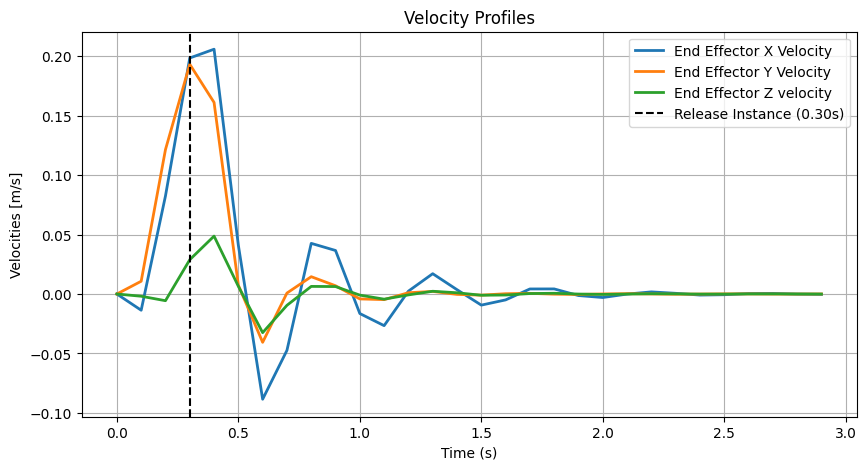

In [ ]:
import matplotlib.patches as patches

# extracting the best parameters
best_params = study.best_params
print("Best Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print(f"\nBest Objective Value (Cost): {study.best_value:.4f}") 
# unpacking the best params 
u1_step = best_params["act1_step"]
u2_step = best_params["act2_step"]
u3_step = best_params["act3_step"]
u_step = np.array([u1_step, u2_step, u3_step])
ramp_steps = best_params["ramp_steps"]
release_step = best_params["release_step"] 

u_data, x_data, velocities, final_land_pos, release_idx, dist = simulate_sys(u_step=u_step, ramp_steps=ramp_steps, release_step=release_step, input_scaler=input_scaler, state_scaler=state_scaler) 

print("final distance: ", dist)

# Time vectors for plotting
time_steps = np.arange(len(x_data)) * dt
time_inputs = np.arange(len(u_data)) * dt

# plot 1: Actuation Profiles
plt.figure(figsize=(10, 5))
plt.plot(time_inputs, u_data[:, 0], label='Actuator 1', linewidth=2)
plt.plot(time_inputs, u_data[:, 1], label='Actuator 2', linewidth=2)
plt.plot(time_inputs, u_data[:, 2], label='Actuator 3', linewidth=2)
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
max_lag = max(lag_input, lag_state)
release_time_plot_u = (release_idx + max_lag) * dt # IN THE U DOMAIN
release_time_plot = (release_idx + max_lag +1) * dt # IN THE X DOMAIN
plt.axvline(x=release_time_plot_u, color='k', linestyle='--', label=f'Actuator Input Corresponding to Release ({release_time_plot_u:.2f}s)')
plt.axvline(x=release_time_plot, color='k', linestyle='--', label=f'Release Instance ({release_time_plot:.2f}s)')
plt.title('Optimal Input Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Actuation Input')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 2D End Effector Trajectory (X-Y)
plt.figure(figsize=(8, 8))
plt.plot(x_data[:, ee_x_idx], x_data[:, ee_y_idx], 'b-', linewidth=2, label='Trajectory')
# Mark start
plt.plot(x_data[0, ee_x_idx], x_data[0, ee_y_idx], 'go', label='Start') 
# Mark end 
plt.plot(x_data[-1, ee_x_idx], x_data[-1, ee_y_idx], 'ko', label='End') 
# Mark release point
plt.plot(x_data[release_idx, ee_x_idx], x_data[release_idx, ee_y_idx], 'ro', label='Release Point')
# Mark landing point and desired landing point 
plt.plot(final_land_pos[0], final_land_pos[1], 'rx', label='Landing Point')
plt.plot(des_land_pos[0], des_land_pos[1], 'kx', label='Desired Landing Point')
plt.title('End Effector Trajectory (X-Y)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.axis('equal')
plt.grid(True) 
cx, cy = x_intial[3], x_intial[4] 
half = 0.2 # how far from the center 
ax = plt.gca()
ax.set_xlim(cx - half, cx + half)
ax.set_ylim(cy - half, cy + half)
ax.set_aspect('equal', adjustable='box')  # optional: square scaling
plt.tight_layout() # adjust padding so labels and titles dont get clipped in the saved file 
plt.show() 

# Plot 3: Landing Targets
plt.figure(figsize=(8, 8))
# Plot Desired
plt.scatter(des_land_pos[0], des_land_pos[1], color='green', s=200, marker='X', label='Desired Landing')
# Plot Actual
plt.scatter(final_land_pos[0], final_land_pos[1], color='red', s=150, marker='o', label='Predicted Landing')
# Draw line connecting them
plt.plot([des_land_pos[0], final_land_pos[0]], [des_land_pos[1], final_land_pos[1]], 'k--', alpha=0.5)

# Add circles for visual context (distance error)
error = np.linalg.norm(final_land_pos - des_land_pos)
circle = plt.Circle(des_land_pos, error, color='gray', fill=False, linestyle=':', alpha=0.5)
plt.gca().add_patch(circle)

plt.title(f'Landing Accuracy\nError: {error:.4f} m')
plt.xlabel('X Landing (m)')
plt.ylabel('Y Landing (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show() 

# plot 4: Velocity profile 
plt.figure(figsize=(10, 5))
plt.plot(time_steps, velocities[:, ee_x_idx], label='End Effector X Velocity', linewidth=2)
plt.plot(time_steps, velocities[:, ee_y_idx], label='End Effector Y Velocity', linewidth=2)
plt.plot(time_steps, velocities[:, ee_z_idx], label='End Effector Z velocity', linewidth=2)
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
release_time_plot_v = (release_idx) * dt 
plt.axvline(x=release_time_plot_v, color='k', linestyle='--', label=f'Release Instance ({release_time_plot_v:.2f}s)')
plt.title('Velocity Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Velocities [m/s]')
plt.legend()
plt.grid(True)
plt.show() 

# Plot 5: Absolute Velocity Profile
ee_vel_indices = [ee_x_idx, ee_y_idx, ee_z_idx]
v_abs = np.linalg.norm(velocities[:, ee_vel_indices], axis=1) 
plt.figure(figsize=(10, 5))
plt.plot(time_steps, v_abs, label='End Effector Absolute Velocity', linewidth=2, color='purple')
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
release_time_plot_v = (release_idx) * dt 
plt.axvline(x=release_time_plot_v, color='k', linestyle='--', label=f'Release Instance ({release_time_plot_v:.2f}s)')
plt.title('Absolute Velocity (Magnitude) Profile')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Magnitude [m/s]')
plt.legend()
plt.grid(True)
plt.show()

saving the best inputs as a .csv file

In [15]:
df = pd.DataFrame(u_data, columns=["U1", "U2", "U3"]) # conversion to pd DF 
df.to_csv("optimal_inputs.csv", index = False) # saving as csv  
print("optimal input shape: ",u_data.shape) 

optimal input shape:  (32, 3)


starting the sorosimpp ROS simulator and the controller + logger 

In [16]:
import roslaunch 
import rospy 
import rospkg
import time 
import subprocess # Added to run terminal commands

# closing any active nodes (to prevent errors)
print("closing any active nods")
try:
    # 'rosnode kill -a' kills all nodes currently registered with the master
    # supress output to keep console clean
    subprocess.call(["rosnode", "kill", "-a"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # time to actually close
    time.sleep(2) 
except Exception as e:
    print("warning during closing (master might not be running yet):", e)

# finding the ros packages dynamically
rospack = rospkg.RosPack() 
pkg_path_sorosimpp = rospack.get_path('sorosimpp_compiled') 
pkg_path_throw = rospack.get_path('sorosimpp_bayopt_throw') 
launch_file_path_sorosimpp = pkg_path_sorosimpp + '/launch/sorosimpp_vis.launch' 
launch_file_path_controller_logger = pkg_path_throw + '/launch/controller_logger.launch' 

# configuring the launch parent 
uuid = roslaunch.rlutil.get_or_generate_uuid(None, False)
roslaunch.configure_logging(uuid)

# creating the launch parent object 
launch_sorosimpp = roslaunch.parent.ROSLaunchParent(uuid, [launch_file_path_sorosimpp]) 
launch_controller_logger = roslaunch.parent.ROSLaunchParent(uuid, [launch_file_path_controller_logger]) 

# starting the launch files 
print("starting the sorosimpp launch file")
launch_sorosimpp.start() 
rospy.sleep(3) 
print("starting the controller and logger launch file") 
launch_controller_logger.start() 

# running for a while 
try:
    rospy.sleep(5) 
except rospy.ROSInterruptException:
    pass

# stopping the launch files 
print("shutting down the controller and logger launch file")
launch_controller_logger.shutdown() 
rospy.sleep(3) 
launch_sorosimpp.shutdown()


closing any active nods
... logging to /home/ahmad_rahmani/.ros/log/8d75f27c-fb7c-11f0-9c56-756eefc959ee/roslaunch-DESKTOP-K46OLN1-27264.log
starting the sorosimpp launch file
started roslaunch server http://DESKTOP-K46OLN1:45790/

SUMMARY

PARAMETERS
 * /continuum_soft_manipulator/actuation/actuator0/phase: 0.0
 * /continuum_soft_manipulator/actuation/actuator0/radius: 0.08
 * /continuum_soft_manipulator/actuation/actuator0/type: constant
 * /continuum_soft_manipulator/actuation/actuator1/phase: 120.0
 * /continuum_soft_manipulator/actuation/actuator1/radius: 0.08
 * /continuum_soft_manipulator/actuation/actuator1/type: constant
 * /continuum_soft_manipulator/actuation/actuator2/phase: 240.0
 * /continuum_soft_manipulator/actuation/actuator2/radius: 0.08
 * /continuum_soft_manipulator/actuation/actuator2/type: constant
 * /continuum_soft_manipulator/discretization/gaussian_points: 5
 * /continuum_soft_manipulator/discretization/orders/bending_y: 0
 * /continuum_soft_manipulator/discre

visualizing the ROS simulation results

ROS simulation logs shape:  (35, 9)


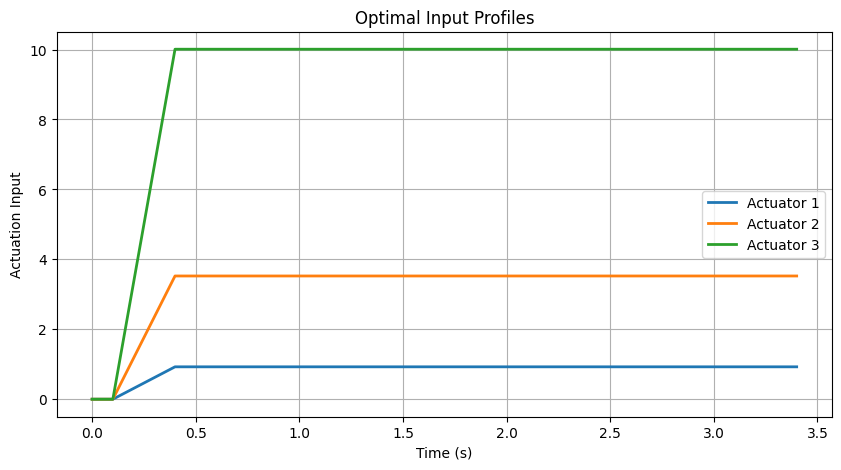

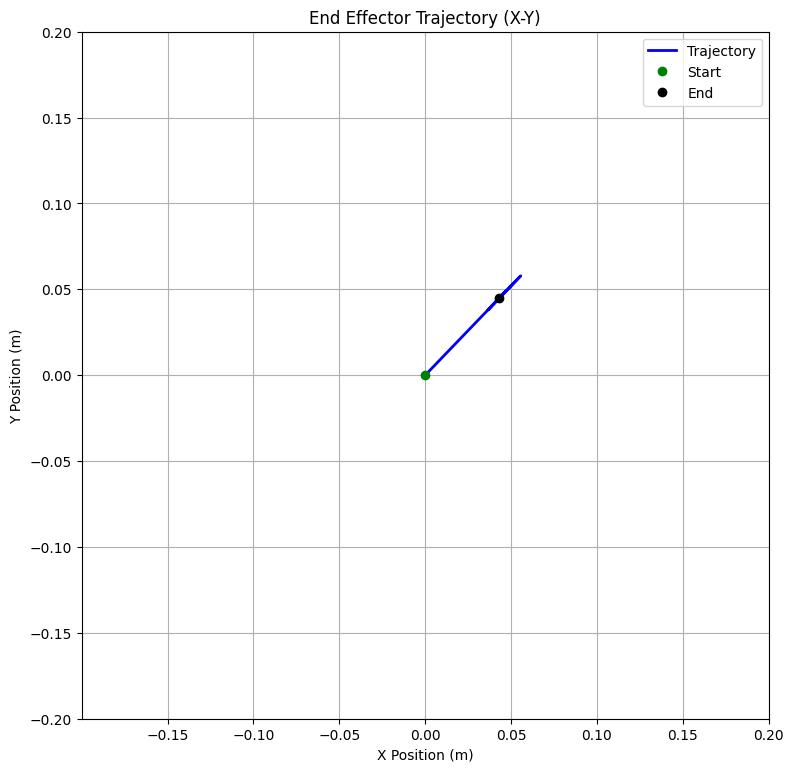

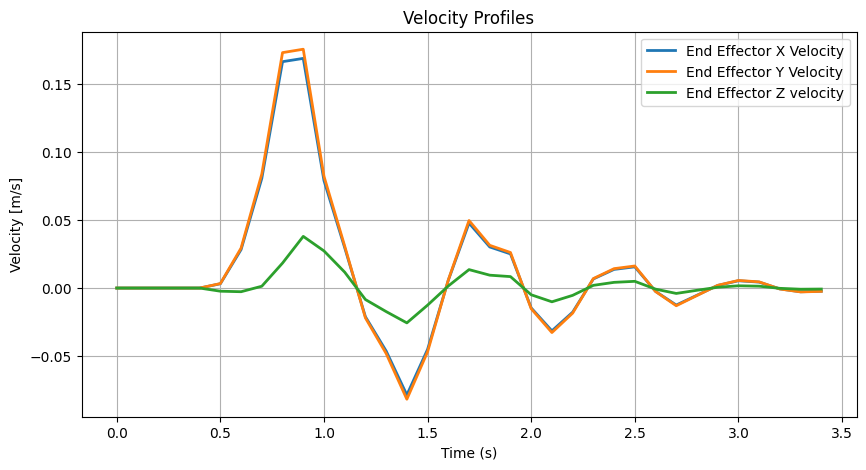

In [17]:
# reading the csv file, setting time to index and conversion to numpy arrays
ros_sim_logs_filename = "ROS_sim_logs.csv" 
ros_sim_logs_path = os.path.join(script_path, ros_sim_logs_filename) 
df = pd.read_csv(ros_sim_logs_path, header=0)  
df.set_index('time', inplace=True)
ros_sim_logs = df.to_numpy() 
print("ROS simulation logs shape: ", ros_sim_logs.shape) 

# extracting the inputs and states
u_data = ros_sim_logs[:, act_1_idx_ros:mid_x_idx_ros]
x_data = ros_sim_logs[:, mid_x_idx_ros:] 

# calculating the velocties 
diff = np.diff(x_data, axis=0) 
velocities = np.vstack([np.zeros((1, n_states)), diff / dt])

# Time vectors for plotting
time_steps = np.arange(len(ros_sim_logs)) * dt
time_inputs = np.arange(len(ros_sim_logs)) * dt

# plot 1: Actuation Profiles
plt.figure(figsize=(10, 5))
plt.plot(time_inputs, u_data[:, 0], label='Actuator 1', linewidth=2)
plt.plot(time_inputs, u_data[:, 1], label='Actuator 2', linewidth=2)
plt.plot(time_inputs, u_data[:, 2], label='Actuator 3', linewidth=2)
'''
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
max_lag = max(lag_input, lag_state)
release_time_plot_u = (release_idx + max_lag) * dt # IN THE U DOMAIN
release_time_plot = (release_idx + max_lag +1) * dt # IN THE X DOMAIN
plt.axvline(x=release_time_plot_u, color='k', linestyle='--', label=f'Actuator Input Corresponding to Release ({release_time_plot_u:.2f}s)')
plt.axvline(x=release_time_plot, color='k', linestyle='--', label=f'Release Instance ({release_time_plot:.2f}s)')
'''
plt.title('Optimal Input Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Actuation Input')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 2D End Effector Trajectory (X-Y)
plt.figure(figsize=(8, 8))
plt.plot(x_data[:, ee_x_idx], x_data[:, ee_y_idx], 'b-', linewidth=2, label='Trajectory')
# Mark start
plt.plot(x_data[0, ee_x_idx], x_data[0, ee_y_idx], 'go', label='Start') 
# Mark end 
plt.plot(x_data[-1, ee_x_idx], x_data[-1, ee_y_idx], 'ko', label='End') 
# Mark release point
#plt.plot(x_data[release_idx, ee_x_idx], x_data[release_idx, ee_y_idx], 'ro', label='Release Point')
# Mark landing point and desired landing point 
#plt.plot(final_land_pos[0], final_land_pos[1], 'rx', label='Landing Point')
#plt.plot(des_land_pos[0], des_land_pos[1], 'kx', label='Desired Landing Point')
plt.title('End Effector Trajectory (X-Y)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.axis('equal')
plt.grid(True) 
cx, cy = x_data[0, ee_x_idx], x_data[0, ee_y_idx] 
half = 0.2 # how far from the center 
ax = plt.gca()
ax.set_xlim(cx - half, cx + half)
ax.set_ylim(cy - half, cy + half)
ax.set_aspect('equal', adjustable='box')  # optional: square scaling
plt.tight_layout() # adjust padding so labels and titles dont get clipped in the saved file 
plt.show() 
'''
# Plot 3: Landing Targets
plt.figure(figsize=(8, 8))
# Plot Desired
plt.scatter(des_land_pos[0], des_land_pos[1], color='green', s=200, marker='X', label='Desired Landing')
# Plot Actual
plt.scatter(final_land_pos[0], final_land_pos[1], color='red', s=150, marker='o', label='Predicted Landing')
# Draw line connecting them
plt.plot([des_land_pos[0], final_land_pos[0]], [des_land_pos[1], final_land_pos[1]], 'k--', alpha=0.5)

# Add circles for visual context (distance error)
error = np.linalg.norm(final_land_pos - des_land_pos)
circle = plt.Circle(des_land_pos, error, color='gray', fill=False, linestyle=':', alpha=0.5)
plt.gca().add_patch(circle)

plt.title(f'Landing Accuracy\nError: {error:.4f} m')
plt.xlabel('X Landing (m)')
plt.ylabel('Y Landing (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show() 
'''
# plot 4: Velocity profile 
plt.figure(figsize=(10, 5))
plt.plot(time_steps, velocities[:, ee_x_idx], label='End Effector X Velocity', linewidth=2)
plt.plot(time_steps, velocities[:, ee_y_idx], label='End Effector Y Velocity', linewidth=2)
plt.plot(time_steps, velocities[:, ee_z_idx], label='End Effector Z velocity', linewidth=2)
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
'''
release_time_plot_v = (release_idx) * dt 
plt.axvline(x=release_time_plot_v, color='k', linestyle='--', label=f'Release Instance ({release_time_plot_v:.2f}s)')
'''
plt.title('Velocity Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.show()